# Comparison of ESPResSo to AMReX Fluctuating Hydrodynamics (FHD) implementation

[Standing water](#Water)

[Input file](#Input-file)

[Run catalogue](#Run-catalogue-starting-14th-June-2022)

[ESPResSo](#ESPResSo-sources)

[References](#References)

In [1]:
import numpy as np
from sympy import *
from sympy.solvers.solveset import linsolve
from vtk import vtkStructuredPointsReader, vtkXMLImageDataReader
from pyevtk.hl import imageToVTK
from vtk.util import numpy_support as VN
import glob
from numpy.fft import fftn,fftfreq
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import os
from helper import *
from scipy.signal import correlate

In [7]:
a = np.random.randint(0, 5 , (2, 2, 2, 3, 3))

test = correlate(a, a, mode = 'same')
test, a

(array([[[[[  0,   4,  12],
           [  4,  19,   8],
           [ 13,  22,  18]],
 
          [[ 12,  41,  25],
           [ 33,  52,  28],
           [ 32,  34,  17]]],
 
 
         [[[ 22,  36,  26],
           [ 35,  74,  50],
           [ 29,  34,  32]],
 
          [[ 44,  60,  34],
           [ 83, 122,  76],
           [ 60,  85,  37]]]],
 
 
 
        [[[[ 11,  37,  28],
           [ 34,  54,  40],
           [ 37,  46,  38]],
 
          [[ 52,  70,  51],
           [ 78,  90,  61],
           [ 55,  75,  44]]],
 
 
         [[[ 40,  63,  43],
           [ 88, 132,  94],
           [ 51,  69,  33]],
 
          [[ 86, 147, 121],
           [192, 410, 192],
           [121, 147,  86]]]]]),
 array([[[[[0, 0, 4],
           [1, 1, 0],
           [2, 3, 1]],
 
          [[2, 4, 3],
           [3, 2, 1],
           [3, 0, 3]]],
 
 
         [[[4, 2, 4],
           [0, 3, 2],
           [2, 2, 4]],
 
          [[1, 0, 1],
           [1, 0, 3],
           [3, 3, 1]]]],
 
 
 
     

## Compiling ESPResSo

`sudo apt-get install libboost-all-dev`

`cd ~/Documents`

`git clone https://github.com/espressomd/espresso.git`

`sudo apt install build-essential cmake cython3 python3-pip python3-numpy \
  libboost-all-dev openmpi-common fftw3-dev libhdf5-dev libhdf5-openmpi-dev \
  python3-opengl libgsl-dev`
  
`sudo apt install cmake-curses-gui`

`sudo apt install nvidia-cuda-toolkit`

`sudo apt install doxygen graphviz`

`sudo apt install python3-matplotlib python3-pint python3-tqdm ffmpeg
pip3 install --user 'MDAnalysis>=1.0.0,<2.0.0'`

`pip3 install --user nbformat notebook 'jupyter_contrib_nbextensions==0.5.1'`

`jupyter contrib nbextension install --user
jupyter nbextension enable rubberband/main
jupyter nbextension enable exercise2/main`

`cd espresso`

`mkdir build`

`cd build`

`CC=gcc-7 CXX=g++-7 cmake -DWITH_CUDA=ON ..`

`cmake --build . -j 4`

## Water

This setup is to validate the single phase case for a Fluctuating Hydrodynamics implementation in AMReX. The simulation to be simulated is to replicate the structure factors in the x and y directions that is obtained by simulating water. The simulation space is a cube of length $64 \mu m$ at $37^{\circ}C$ with periodic boundary conditions

ESPResSo is being used to validate the implementation in AMReX as it is a well known software that has been used before. To allow for the simulation of the above system, water at the specified temperature has properties $\rho = 993.36 \frac{kg}{m^3}$, $\nu = 6.969 \cdot 10^{-7} \frac{m^2}{s}$. The speed of sound in water is $1480 \frac{m}{s}$

<!-- For the third degree of freedom, the Boltzmann number will be utilized. This is defined as,

$$ Bo = \frac{k_b T }{m c_s^2}(\frac{d}{\Delta x})^3$$

Where $k_b$ is the boltzmann constant, $T$ is the temperature, $m$, $c_s$ is the speed of sound in the medium, $d$ is the mean intermolecular separation and $\Delta x$ is the lattice spacing in real units. d is in the order of $0.3 nm$.  -->

Therefore, to obtain the conversions from lattice space to real space, the following three equations are used

$$ \rho_{sim} (\frac{\Delta m}{\Delta x^3}) = 993.36 \frac{kg}{m^3} $$

$$ \nu_{sim} (\frac{\Delta x^2}{\Delta t}) = 6.969 \cdot 10^{-7} \frac{m^2}{s} $$

<!-- $$ \frac{1}{3} (\frac{\Delta x}{\Delta t}) = 1480 \frac{m}{s}$$ -->

$$ k_b T(37^{\circ}C) = 4.28\cdot10^{-21} \frac{kg m^2}{s^2} = k_{b}^{sim}\hat{T} \frac{\Delta m \Delta x^2}{\Delta t^2}$$

$\Delta x = 1\mu m$ as we want to specify a system which is $64^3$ in size and $64 \mu m$. Our unknowns from the above equations are $\Delta t$, $\Delta m$ and $\hat{T}$. The code below solves for these unknowns. 

## Expected Results

The expected results are derived from the structure factors obtained from the simulation. These are derived from the sum of the density, velocities and pressure tensors. From the balboa paper shared, the solutions for the various structure factors are, 

$$S_{\rho, \rho} = \langle (\hat{\delta \rho}) (\hat{\delta \rho})^{*} \rangle = \frac{\rho_0 k_b T_0}{c_T^2} = 3 k_b T$$

$$S_{v, v} = \langle (\hat{\delta v}) (\hat{\delta v})^{*} \rangle = \frac{k_b T_0}{\rho_0} \mathbf{I} = k_b T \mathbf{I}$$

<!-- $$S_{c, c} = \langle (\hat{\delta c}) (\hat{\delta c})^{*} \rangle = \frac{M c_0 (1- c_0)}{\rho_0}$$ -->

## Input file

In [33]:
input_file = '''
import espressomd
import espressomd.lb
import numpy as np
import os
import time
from pyevtk.hl import imageToVTK
from numpy.fft import fftn,fftfreq
import matplotlib.pyplot as plt
import sys
from helper import *
from scipy.signal import correlate

print('')
### Parameters ###
timesteps = int(sys.argv[1])
ag = 1.0 # agrid
d = 1 # density
v = float(sys.argv[2]) # viscosity
t = 1 # tau
L = 64 # side length
test = convert_lb(nu_sim = v, rho_sim = d)
kbT = test['T'] #2.464*10**(-7)
cs = 1/np.sqrt(3)
dim = 3
################

### Setup ###
system = espressomd.System(box_l=[L]*3)
system.time_step = 1
system.cell_system.skin = 0.0

lbfluid = espressomd.lb.LBFluid(agrid = ag, dens = d, visc = v, tau = t, kT = kbT, seed=134)
system.actors.add(lbfluid)
print(lbfluid.get_params())
uid = np.random.randint(0, 1001)
###############

### Time Loop ###
window = 20

S_v = np.zeros((*[L]*dim,dim,dim), dtype = complex)
S_rho = np.zeros((*[L]*dim, 1, 1), dtype = complex)
S_p = np.zeros((*[L]*3,dim,dim), dtype = complex)

#time_corr = np.zeros((window, L, L, L, dim, dim))
P_arr = np.zeros((window, L, L, L, dim, dim))

auto_corr_np = np.zeros((window, L, L, L, dim, dim))

start = time.time()
for i in range(int(timesteps + 1)): 
    system.integrator.run(steps = 1)
    lbf = lbfluid[:, :, :]
    
    #### Density ####
    rho = lbf.density
    rk = fftn(rho)
    S_rho[..., 0, 0] += rk*np.conj(rk)
    #print('Density obtained: ', i)
    
    #### Velocity ###
    vel = lbf.velocity
    vk = fftn(vel, axes = [0, 1, 2])
    S_v += np.einsum('...i,...j->...ij',vk,np.conj(vk))
    #print('Velocity obtained: ', i)
    
    #if i%out_time == 0: lbfluid.write_vtk_velocity(file_out+'/v_{0}.vtk'.format(i))
    #################
    
    ### Pressure ### 
    p = lbf.pressure_tensor_neq
    kp = fftn(p, axes = [0, 1, 2])
    S_p += kp*np.conj(kp)
    
    if i < window:
        P_arr[i] = p
    else:
#        time_corr = get_autocorr(time_corr, P_arr, i)
#        auto_corr_np = correlate(P_arr, P_arr, mode = 'same', method = 'direct')
        for j in range(3):
            for k in range(3):
                auto_corr_np[..., j, k] = correlate(P_arr[..., j, k], P_arr[..., j, k], mode = 'same')
        P_arr[:-1] = P_arr[1:]; P_arr[-1] = p
    
    #print('Pressure obtained: ', i)
    ################
    current_time = time.strftime("%H:%M:%S", time.localtime())
    print(current_time, ': Timestep ', i)

end = time.time()

print('Run UID = ', uid)
print('{0} Timesteps run in {1:.3f}s, average of {2:.3f} s/timesteps'.format(timesteps, end - start, (end - start)/timesteps))
#################

### Post Processing ###
d_corr = {'eta_xx':(0, 0), 'eta_xy':(0, 1), 'eta_xz':(0, 2), 'eta_yx':(1, 0), 'eta_yy':(1, 1), 'eta_yz':(1, 2), 'eta_zx':(2, 0), 'eta_zy':(2, 1), 'eta_zz':(2, 2)}
d_rho = {'rho':(0, 0)}
d_v = {'V_xx':(0, 0), 'V_xy':(0, 1), 'V_xz':(0, 2), 'V_yx':(1, 0), 'V_yy':(1, 1), 'V_yz':(1, 2), 'V_zx':(2, 0), 'V_zy':(2, 1), 'V_zz':(2, 2)}
d_p = {'P_xx':(0, 0), 'P_xy':(0, 1), 'P_xz':(0, 2), 'P_yx':(1, 0), 'P_yy':(1, 1), 'P_yz':(1, 2), 'P_zx':(2, 0), 'P_zy':(2, 1), 'P_zz':(2, 2)}

names = list(d_corr.keys())
print(auto_corr_np.shape)
eta_all = np.sum(np.mean(auto_corr_np, axis = (1, 2, 3)), axis = (0))/kbT
print(eta_all.shape)
dim1 = ['x', 'y', 'z']
for i in range(len(dim1)):
    for j in range(len(dim1)):
        print('eta-'+names[i%3*3 + j]+':', str(eta_all[i, j]))

S_v /= (timesteps*L**3*kbT)
S_rho /= (timesteps*L**3*kbT)
S_p /= (timesteps*L**3*kbT)

S_rho = np.abs(S_rho)
S_v = np.abs(S_v)
S_p = np.abs(S_p)

print('Average density: ',[ [ np.mean(S_rho[...,i,j]) for i in range(S_rho.shape[-2]) ] for j in range (S_rho.shape[-1]) ])
print('Average velocity: ',[ [ np.mean(S_v[...,i,j]) for i in range(S_v.shape[-2]) ] for j in range (S_v.shape[-1]) ])
print('Average pressure: ',[ [ np.mean(S_p[...,i,j]) for i in range(S_p.shape[-2]) ] for j in range (S_p.shape[-1]) ])
########################

### Output ####
#file_out = os.getcwd() + '/gb_test/uid_{0}'.format(uid)
#file_out = os.getcwd() + '/gb_test/test'
file_out = sys.argv[3]
print('output file: ', file_out)

try:
    os.makedirs(file_out)
except FileExistsError:
    print("Folder exists")
###############

### Exporting data ###
print('Output begins')
export_map(S_v, d_v.keys(), path = file_out, corr = 'v')
export_map(S_rho, d_rho.keys(), path = file_out, corr = 'rho')
export_map(S_p, d_p.keys(), path = file_out, corr = 'p')
#export_plot(time_corr[:, L//2, L//2, L//2], d_corr.keys(), path = file_out, corr = 'gb_pressure_corr')

#for j in range(time_corr.shape[0]):
#    names = d_corr.keys()
#    d_corr = {'eta_xx':(0, 0), 'eta_xy':(0, 1), 'eta_xz':(0, 2), 'eta_yx':(1, 0), 'eta_yy':(1, 1), 'eta_yz':(1, 2), 'eta_zx':(2, 0), 'eta_zy':(2, 1), 'eta_zz':(2, 2)}
#    for i, name in enumerate(names):
#        index = d_corr[name]
#        d_corr[name] = np.ascontiguousarray(time_corr[j, ..., index[0], index[1]])
#
#    imageToVTK(file_out + '/gb_corr_{0}'.format(j), pointData = d_corr)
    
for j in range(auto_corr_np.shape[0]):
    names = d_corr.keys()
    d_corr = {'eta_xx':(0, 0), 'eta_xy':(0, 1), 'eta_xz':(0, 2), 'eta_yx':(1, 0), 'eta_yy':(1, 1), 'eta_yz':(1, 2), 'eta_zx':(2, 0), 'eta_zy':(2, 1), 'eta_zz':(2, 2)}
    for i, name in enumerate(names):
        index = d_corr[name]
        d_corr[name] = np.ascontiguousarray(auto_corr_np[j, ..., index[0], index[1]])

    imageToVTK(file_out + '/np_corr_{0}'.format(j), pointData = d_corr)

names = d_rho.keys()
for i, name in enumerate(names):
    index = d_rho[name]
    d_rho[name] = np.ascontiguousarray(np.abs(S_rho[..., index[0], index[1]]))

names = d_v.keys()

for i, name in enumerate(names):
    index = d_v[name]
    d_v[name] = np.ascontiguousarray(np.abs(S_v[..., index[0], index[1]]))

names = d_p.keys()

for i, name in enumerate(names):
    index = d_p[name]
    d_p[name] = np.ascontiguousarray(np.abs(S_p[..., index[0], index[1]]))

imageToVTK(file_out +'/v_sum', pointData = d_v)
imageToVTK(file_out + '/rho_sum', pointData = d_rho)
imageToVTK(file_out + '/pi_sum', pointData = d_p)
#######################
'''

In [34]:
def process_output(output):
    uid = 0
    file_path = ''
    d_visc = {}
    for i in output:
        if 'UID' in i:
            uid = int(i.split()[-1])
        elif 'output' in i:
            file_path = i.split()[-1]
            with open(file_path + '/log.txt', 'w') as t:
                t.write('\n'.join(output))
            os.system('cp ./script.py {0}'.format(file_path))
        elif 'eta' in i:
            eta = i.split(':')
            d_visc[eta[0]] = float(eta[-1])
    return (file_path, d_visc)

pwd = os.getcwd()

with open('script.py', 'w') as f:
    f.write(input_file)

In [37]:
from subprocess import Popen, PIPE

tau = np.arange(0.6, 1.3, 0.1)
# tau = np.array([1])
nu = 1/3*(tau - 0.5)
nu, tau

timesteps = 200

output_list_info = []

for i, n in enumerate(nu):
    file_out = os.getcwd() + '/gb_test/nu_{0:.3f}'.format(n)

    format_script_run = './pypresso script.py {0} {1} {2}'.format(timesteps, n, file_out)
    split_list = format_script_run.split()

    process = Popen(split_list, stdout=PIPE, stderr=PIPE)
    
    stdout, stderr = process.communicate()
    
    with open(file_out + '/log.txt', 'wb') as f:
        f.write(stdout)
        
    with open(file_out + '/log.txt') as f:
        contents = f.readlines()
        
    output_list_info.append(process_output(contents))

In [40]:
output_list_info, nu

([('/home/nikhil/Documents/fhd_test/single_phase/gb_test/nu_0.033',
   {'eta-eta_xx': 373979482933658.6,
    'eta-eta_xy': -0.07722336685886923,
    'eta-eta_xz': 0.12328962486611947,
    'eta-eta_yx': -0.07722336685886923,
    'eta-eta_yy': 373979478075637.4,
    'eta-eta_yz': 0.26050602737254497,
    'eta-eta_zx': 0.12328962486611947,
    'eta-eta_zy': 0.26050602737254497,
    'eta-eta_zz': 373979493510145.6}),
  ('/home/nikhil/Documents/fhd_test/single_phase/gb_test/nu_0.067',
   {'eta-eta_xx': 93494942564084.6,
    'eta-eta_xy': 0.04075659368178004,
    'eta-eta_xz': 1.1963611135119834,
    'eta-eta_yx': 0.04075659368178004,
    'eta-eta_yy': 93494935436228.5,
    'eta-eta_yz': 1.0561198411850252,
    'eta-eta_zx': 1.1963611135119834,
    'eta-eta_zy': 1.0561198411850252,
    'eta-eta_zz': 93494957226864.78}),
  ('/home/nikhil/Documents/fhd_test/single_phase/gb_test/nu_0.100',
   {'eta-eta_xx': 41553351300013.55,
    'eta-eta_xy': 0.40438866525421974,
    'eta-eta_xz': 3.3602203768

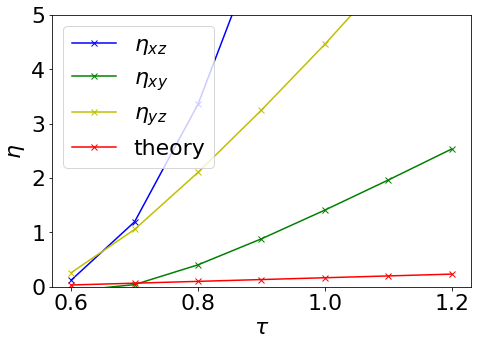

In [67]:
output_list_info = np.array(output_list_info)
eta_all = output_list_info[:, 1]
paths = output_list_info[:, 0]

nu_real = np.zeros((3, nu.size))

fig, axs = plt.subplots(1, 1, figsize = (7.5, 5))

for i in range(0, nu.size):
    d = eta_all[i]
    nu_real[0, i] = d['eta-eta_xz']
    nu_real[1, i] = d['eta-eta_xy']
    nu_real[2, i] = d['eta-eta_yz']

axs.plot(tau, nu_real[0], '-bx', label = '$\eta_{xz}$')
axs.plot(tau, nu_real[1], '-gx', label = '$\eta_{xy}$')
axs.plot(tau, nu_real[2], '-yx', label = '$\eta_{yz}$')
axs.plot(tau, nu, '-rx', label  = 'theory')
axs.set(xlabel = r'$\tau$', ylabel = r'$\eta$', ylim = (0, 5))
axs.legend()
fig.savefig(os.getcwd() + '/summary.png')

In [25]:
file_path_14 = '/home/nikhil/Documents/fhd_test/single_phase/gb_test/uid_857'
d_14 = convert_lb(nu_sim = 1/4, rho_sim = 1, T_real = 37)

file_path_112 = '/home/nikhil/Documents/fhd_test/single_phase/gb_test/uid_584'
d_112 = convert_lb(nu_sim = 1/12, rho_sim = 1, T_real = 37)

file_path_16 = '/home/nikhil/Documents/fhd_test/single_phase/gb_test/uid_102'
d_16 = convert_lb(nu_sim = 1/6, rho_sim = 1, T_real = 37)

vti_files = sorted(glob.glob(file_path_16 + '/corr*vti'))
T = d_16['T']

dim_assign, headers = read_vti(vti_files[0])

all_files = np.zeros((len(vti_files), *dim_assign.shape))

for i, path in enumerate(vti_files):
    all_files[i] = read_vti(vti_files[i])[0]

all_files = all_files.reshape((len(vti_files), 64, 64, 64, 3, 3))/(64**3)*T

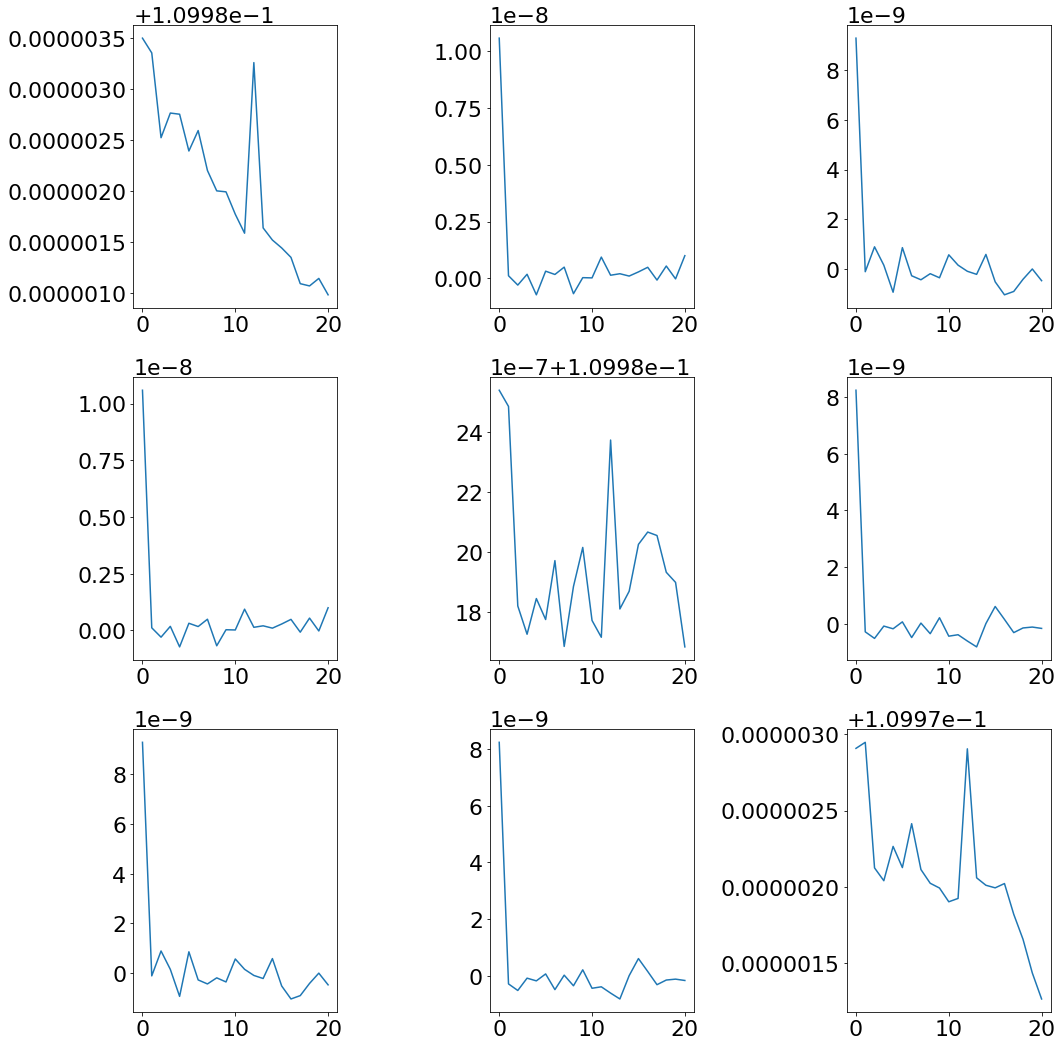

In [26]:
fig, axes = plt.subplots(3,3, figsize = (15, 15))
for i,ax1 in enumerate(axes):
    for j,ax in enumerate(ax1):
        ax.plot(all_files[:21, 64//2, 64//2, 64//2, i, j])
        
fig.tight_layout()

In [63]:
from scipy.optimize import fsolve

# scipy.optimize.fsolve(func, x0, args=(), fprime=None, full_output=0, col_deriv=0, xtol=1.49012e-08, maxfev=0, band=None, epsfcn=None, factor=100, diag=None)

def T_theory(x, u):
    T = u[0]
    l = u[1]
    phi = x[0]
    
    eq = T - (l*phi)/np.log( (1 + phi)/(1 - phi) )
    return [eq]

fsolve(T_theory, [0.5], [0.5, 1.1]).round(3)

array([0.503])

In [27]:
# test = np.mean(np.sum(all_files, axis = 0), axis = (0, 1, 2))
test = np.sum(np.mean(all_files, axis = (1, 2, 3)), axis = (0))/T
# test = np.mean(all_files, axis = (0, 1, 2, 3))/T

print(test, T)



# fig, axes = plt.subplots(3,3, figsize = (15, 15))
# for i,ax1 in enumerate(axes):
#     for j,ax in enumerate(ax1):
#         ax.plot(test[:, 64//2, 64//2, i*3 + j])

[[4.46284765e+07 8.25910721e-02 8.25603713e-02]
 [8.25910721e-02 4.46284689e+07 8.25356172e-02]
 [8.25603713e-02 8.25356172e-02 4.46284773e+07]] 2.4643073853796444e-07


#### Run catalogue starting 14th June 2022

| uid | run success | variables collected | timesteps | analysis success | remarks |
| :---: | :---: | :---: | :---: | :---: | :---: |
| 19 | y | $\rho$, v, $\pi$ | $8000$ | n | data collection was discovered to be incorrect |
| 9 | y | v | need to run longer | $10^5$ | data collection is correct but run needs to be longer than $10^4$ $\delta t$ |
| 861 | y | v | $10^4$ | N/A | testing espresso native version | 
| 464 | y | v | $10^4$ | n | too few data points in espresso native version | 
| 167 | y | v | $10^5$ | n | too few data points in espresso native version |
| 192 | n | v | $10^6$ | n | memory overflow caused process to be killed. 1000 readings too much  |
| 842 | y | v | $10^4$ | n | checking if np subroutine is causing failure in analysis |
| 475 | y | v | $10^4$ | n | for loop confers better results than np indexing. Will see maximum number of steps that can be obtained. Currently taking 100 observances |
| 610 | n | v | $10^4$ | n | 500 observances causes issues |
| 845 | y | v | $10^4$ | n | 250 observances is succesful |
| 891 | y | v | $10^6$ | n | Did not produce the correct result. Will try running $10^5$ timesteps first then restart from that location |
| 37 | y | v | $10^5$ | N/A | Checkpoint generation at $10^5$ timesteps |
| 37 | y | v | $10^6$ | N/A | Checkpoint generated at $10^6$. Script in `script_restart.py`. Integration of checkpoint into ipython script. Unfortunately overwrote the original checkpoint file |
| 288 | y | v | $10^5$ | N/A | Checkpoint generation at $10^5$ timesteps |
| 288 | y | v | $10^6$ | N/A | Checpoint at $10^5$ restart done to $10^6$. Using paraview to visualize output `.vti` file. Paraview shows that the expected result is not obtained. |
| 721 | y | v | $2*10^4$ | N/A | testing script restarting. Script restarting functional. |
| 149 | y | v | $10^3$ | | Testing to see if vtk output and vti collation in file give the same result |
| 458 | y | v | $10^2$ | | Testing to see if output of `LBVelocity` is equivalent to the vtk output |
| 78 | y | v | $10^2$ | | Testing to see if all outputs gave the same output with bulk viscosity set to $\frac{1}{9}$ |
| 729 | y | v | $10^2$ | | Testing to see if all outputs gave the same output with bulk viscosity set to default (0) |
| 214 | y | v | $10^2$ | | Verification of bulk viscosity settings. $\gamma_{bulk} = \gamma_{even} = \gamma_{odd} = 0$ | 
| 705 | y | v | $10^2$ | n | Found a commented code snippet which is for BGK in `espresso/src/core/grid_based_algorithms/lb.cpp`. Uncommented, compiled to `pypresso_bgk` and run. Did not work. Strongly suspect setup of the LB fluid is incorrect|
| 729 | y | v | $10^2$ | n | using `./pypresso` and trying shorter `tau = 0.01`. Removing object based velocity extraction. Did not work|
| 907 | y | v | $10^2$ | n | using `./pypresso` and trying shorter `tau = 0.01` and `visc = 1.0`. No effect on results.|
| 362 | y | v | $10^2$ | n | using `./pypresso` and trying shorter `tau = 10` and `visc = 1.0`. $\tau$ is wrong|
| 49 | y | v | $10^2$ | n | using `./pypresso` and trying shorter `tau = 0.1` and `visc = 1.0`. $\tau$ is wrong|
| 97 | y | v | $10^2$ | n | using `./pypresso` and trying shorter `tau = 1` and `visc = 1.0`|
| 362 | y | v | $10^2$ | n | using `./pypresso` and trying shorter `tau = 2` and `visc = 1.0`|
| 390 | y | v | $10^2$ | n | using `./pypresso` and trying shorter `tau = 1` and `system.time_step = 1`. Identical to `uid_907`|
| 81 | y | v | $10^2$ | n | using `./pypresso` and trying shorter `tau = 1` and `system.cell_system.skin = 0.0`|
| 108 | y | v | $10^2$ | n | using `./pypresso` and trying shorter `tau = 1` and `system.cell_system.skin = 0.0` and `system.time_step = 0.01`|
| 165 | y | v | $10^2$ | n | using `./pypresso` and trying shorter `tau = 1` and `system.cell_system.skin = 0.0` and `system.time_step = 0.01` and `bulk_visc = 1/9`. Reset to normalized. Maybe run longer?|
| 999 | y | v | $10^4$ | n | using `./pypresso` and trying shorter `tau = 1` and `system.cell_system.skin = 0.0` and `system.time_step = 0.01` and `bulk_visc = 1/9`|

Problem solved when using `./pypresso script.py` rather than `mpirun -n 4 ./pypresso script.py` Now, need to look at the impact of viscosity on the final result. 

| viscosity | timestep | uid | timesteps/s |
| :---: | :---: | :---: | :---: |
| 0.0833  | 1000 | 861 | 0.280 |
| 0.1667 | 1000 |  | 
| 0.25 | 1000 | | |
| 0.3333 | 1000 | | |
| 0.5 | 1000 | | |

## ESPResSo sources

1. https://espressomd.github.io/doc/lb.html#output-for-visualization
2. https://espressomd.github.io/tutorials/lattice_boltzmann/lattice_boltzmann_theory.html
3. https://espressomd.github.io/doc/installation.html#quick-installation

## References

1. 10.1103/PhysRevE.83.046707
2. 10.3389/fphy.2014.00022
3. 10.1016/j.ces.2020.116329